<a href="https://colab.research.google.com/github/benjamincorradini/RECOMMENDATOIION-SYSTEM---SPRINT-3/blob/main/Sprint_3_Recommend_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta un año antes del comienzo del ultimo mes. Desde el ultimo mes de 2014 en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio.

Fecha de entrega: **17 de Abril de 2024**.

Enviar notebook a fausto.sanchez95@gmail.com. Pueden subirlo a un repositorio de github (público) y enviarme el link. De paso les sirve para ir armando su perfil de github con algunos proyectos 😉.



***Path de sistema de recomendacion:***

Objetivo: Para cada account_id , recomendar 20 content_id.


1- Importacion de datos.

2- EDA dataset.

3- Eliminacion de datos no relevantes.

4- Preparacion para aplicar modelo.

5- Cold Start- Popular Products

6- Entrenamiento del modelo.

7- Chequeo del modelo.

8- Evaluacion del modelo.

9- Recomendar 10 productos populares tambien.

## 0 Importacion Librerias

In [1]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808327 sha256=074596cdec49ca7fa67ef7b955048c52a17cfa4f319b05ac3e507059121eb4a1
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [2]:
#from google.colab import drive
import zipfile
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from scipy.sparse import csr_matrix
from lightfm import LightFM
from google.colab import drive # Drive

## 1 Importacion de Datos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importacion dataset Santi
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sprint 3- Recomendation System/ratings_Electronics (1).csv.zip")
df = pd.read_csv("/content/drive/MyDrive/CURSO DATA SCIENCE/A TRABAJOS PRACTICOS/TP 3 - REC SYST/ratings_Electronics (1).csv (2).zip")


SIGNIFICADO DE LAS COLUMNAS:

*   userId : Every user identified with a unique id (First Column)
*   productId : Every product identified with a unique id(Second Column)
*   Rating : Rating of the corresponding product by the corresponding user(Third Column)
*   timestamp : Time of the rating ( Fourth Column)


In [5]:
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [6]:
df.shape

(7824481, 4)

### Agregado de encabezado como fila:

In [7]:
datos_a_agregar =["AKM1MP6P0OYPR","0132793040",5.0,1365811200]
df2 = pd.DataFrame([datos_a_agregar], columns=['userId', 'productId', 'Rating', 'timestamp'])
df2

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200


In [8]:
df.columns = ['userId', 'productId', 'Rating', 'timestamp']

In [9]:
df3 = pd.concat([df, df2])

In [10]:
df3.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [11]:
df3.shape

(7824482, 4)

In [12]:
df = df3
df.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

### Chequeo NaN:

In [13]:
print(df.isnull().sum())

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [14]:
df = df.dropna()

In [15]:
print(df.isnull().sum())

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


### Convertir "timestamp" a formato date

In [16]:
df["timestamp"] = df["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

In [17]:
df.timestamp.dtype

dtype('O')

In [18]:
#CAMBIO EL FORMATO DEL DATO DE LA COLUMNA DE FECHAS
df["timestamp"] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')

In [19]:
df.timestamp.dtype

dtype('<M8[ns]')

## 2-EDA dataset

### Analisis fecha de registros

In [20]:
df.head()

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,2012-07-01
1,A2NWSAGRHCP8N5,0439886341,1.0,2013-04-29
2,A2WNBOD3WNDNKT,0439886341,3.0,2013-07-22
3,A1GI0U4ZRJA8WN,0439886341,1.0,2012-04-18
4,A1QGNMC6O1VW39,0511189877,5.0,2014-04-14


In [21]:
first_reg = df['timestamp'].min()
last_reg = df['timestamp'].max()
print(f"El primer registro del dataset es del dia: {first_reg}")
print(f"El ultimo registro del dataset es del dia: {last_reg}")

El primer registro del dataset es del dia: 1998-12-04 00:00:00
El ultimo registro del dataset es del dia: 2014-07-23 00:00:00


In [22]:
df['año'] = df['timestamp'].dt.year
df['mes'] = df['timestamp'].dt.month

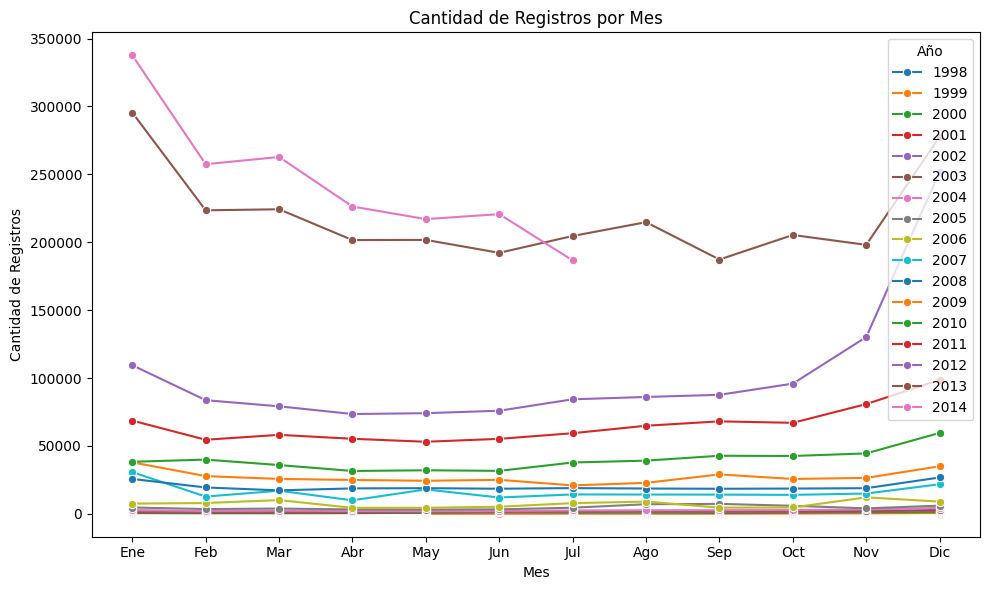

In [23]:
agrupado = df.groupby(['año', 'mes']).size().reset_index(name='cantidad_registros')

# Graficar
plt.figure(figsize=(10, 6))
sns.lineplot(x='mes', y='cantidad_registros', hue='año', data=agrupado, marker='o', palette='tab10')
plt.title('Cantidad de Registros por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año')
plt.tight_layout()
plt.show()

## Seleccion de limites de tiempo

El dataset se basa en registro de scores segun compras de productos en una tienda online.

El la fecha registrada, es la fecha cuando se realizo registro dicho score. Por lo tanto, se podria suponer que es si la ultima vez que se realizo un score de un producto X fue hace 5 años, hace 5 años que dicho producto no se vende (podria ser un producto ya obsoleto).

El criterio que se utilizará, es dejar el registro de los productos vendidos en los años 2013,2014. Ya que sino probablemente se recomiende un producto ya obsoleto o que no esta disponible actualmente.

In [24]:
df = df[df['timestamp'] >= pd.to_datetime('2013-06-23')]

In [25]:
df.shape

(3046384, 6)

El dataset se redujo de 7.824.481 a 2.996.365.

In [26]:
first_reg = df['timestamp'].min()
last_reg = df['timestamp'].max()
print(f"El primer registro del dataset es del dia: {first_reg}")
print(f"El ultimo registro del dataset es del dia: {last_reg}")

El primer registro del dataset es del dia: 2013-06-23 00:00:00
El ultimo registro del dataset es del dia: 2014-07-23 00:00:00


In [27]:
plot = df.groupby(["año","mes"], as_index=False).count()[["año","mes","userId"]]
plot.columns = ["year","month", "reviews_count"]
plot.head()

,year,month,reviews_count
0,2013,6,50019
1,2013,7,204603
2,2013,8,214780
3,2013,9,187266
4,2013,10,205333


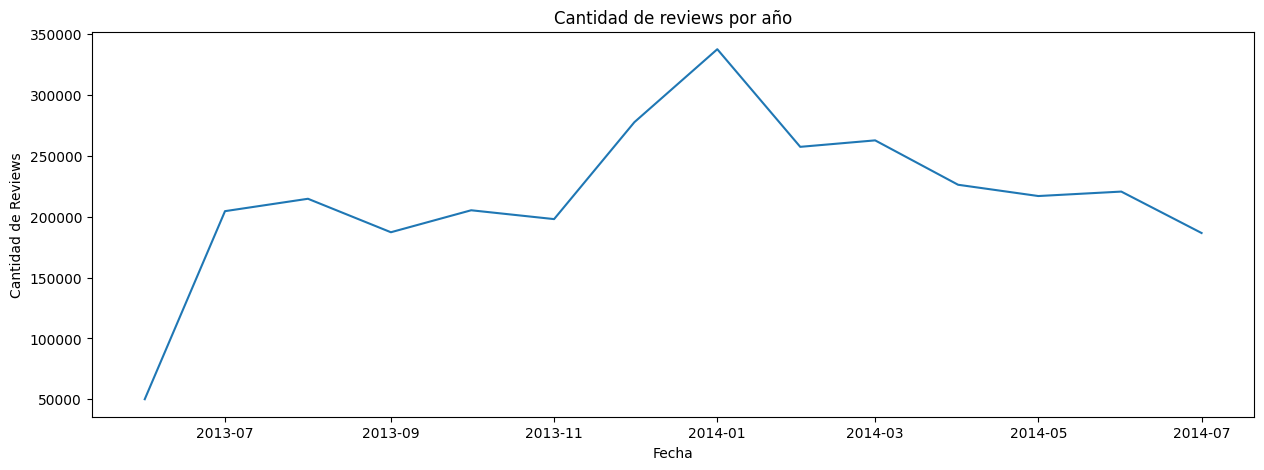

In [28]:
plot['date'] = pd.to_datetime(plot['year'].astype(str) + '-' + plot['month'].astype(str))

plt.figure(figsize=(15,5))
sns.lineplot(x=plot['date'], y=plot['reviews_count'])
plt.title("Cantidad de reviews por año")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Reviews")
plt.show()

### Analisis productos mas comprados

In [29]:
df['productId'].nunique()

273849

In [30]:
most_bought = df.groupby('productId').size().sort_values(ascending=False)
most_bought = most_bought[:10]
most_bought

productId
B00DR0PDNE    16433
B007WTAJTO     9327
B0074BW614     8229
B00BGA9WK2     7558
B009SYZ8OC     7200
B003ELYQGG     6496
B003ES5ZUU     6025
B009A5204K     5857
B00BGGDVOO     5616
B007R5YDYA     5427
dtype: int64

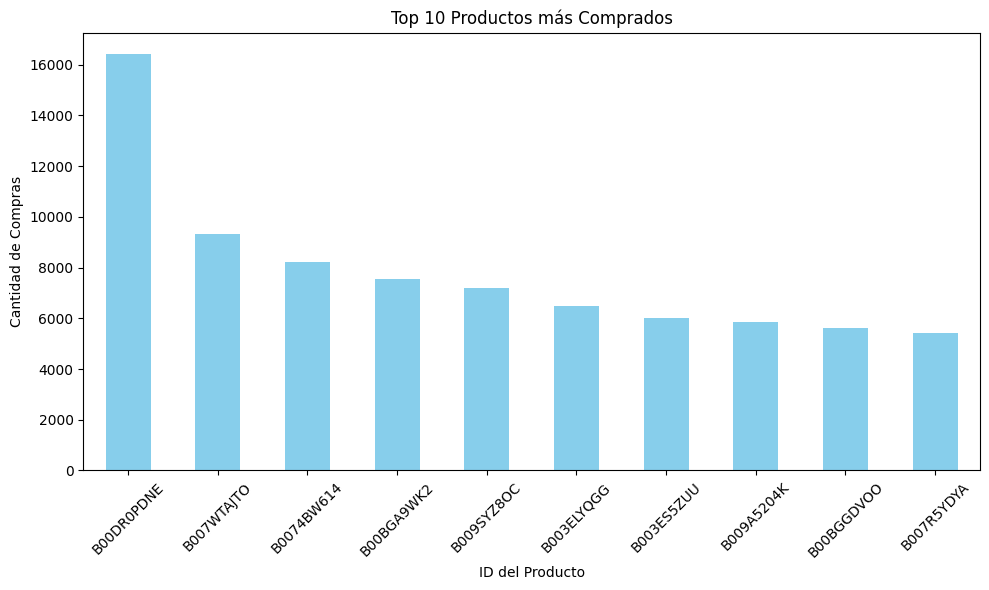

In [31]:
plt.figure(figsize=(10, 6))
most_bought.plot(kind='bar', color='skyblue')
plt.title('Top 10 Productos más Comprados')
plt.xlabel('ID del Producto')
plt.ylabel('Cantidad de Compras')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analisis productos con mejor score

In [32]:
df.head(5)

,userId,productId,Rating,timestamp,año,mes
2,A2WNBOD3WNDNKT,0439886341,3.0,2013-07-22,2013,7
4,A1QGNMC6O1VW39,0511189877,5.0,2014-04-14,2014,4
5,A3J3BRHTDRFJ2G,0511189877,2.0,2014-04-14,2014,4
6,A2TY0BTJOTENPG,0511189877,5.0,2014-03-27,2014,3
7,A34ATBPOK6HCHY,0511189877,5.0,2014-03-23,2014,3


In [33]:
best_products = df.groupby('productId').size() > 100
best_ratings = best_products[best_products].index.tolist()

In [34]:
len(best_ratings)

4672

In [35]:
df_best_rating_100 = df[df['productId'].isin(best_ratings)]
df_best_rating_100

,userId,productId,Rating,timestamp,año,mes
182,A1BKC6B7YHYTVV,0972683275,4.0,2014-07-15,2014,7
183,AWVFSIB42LHKJ,0972683275,4.0,2014-07-13,2014,7
184,A36MQBNADRH8YY,0972683275,5.0,2014-07-18,2014,7
185,A3SRXMPLAEZ6DP,0972683275,4.0,2014-07-22,2014,7
186,A20XXTXWF2TCPY,0972683275,5.0,2014-07-12,2014,7
...,...,...,...,...,...,...
7821567,A2YJYBE8E07C6J,B00KFAGCUM,5.0,2014-07-18,2014,7
7821568,A16H5VQ54ZCR25,B00KFAGCUM,5.0,2014-06-24,2014,6
7821569,A36UTT01QLVU1R,B00KFAGCUM,5.0,2014-07-14,2014,7
7821570,A1SKCXUJO7BARJ,B00KFAGCUM,5.0,2014-06-22,2014,6


In [36]:
df_best_rating_100 = df_best_rating_100.groupby('productId').Rating.mean().sort_values(ascending=False)
df_best_rating_100

productId
B00GMRCAC6    4.951872
B00CG70K78    4.946429
B00FX9WJNO    4.917241
B006TAP096    4.889908
B003RCEAB8    4.885906
                ...   
B0065S2Y64    1.747899
B005QWH4QA    1.736025
B00DVQF1F4    1.709677
B009LVVTSQ    1.707143
B0084JXKLA    1.671756
Name: Rating, Length: 4672, dtype: float64

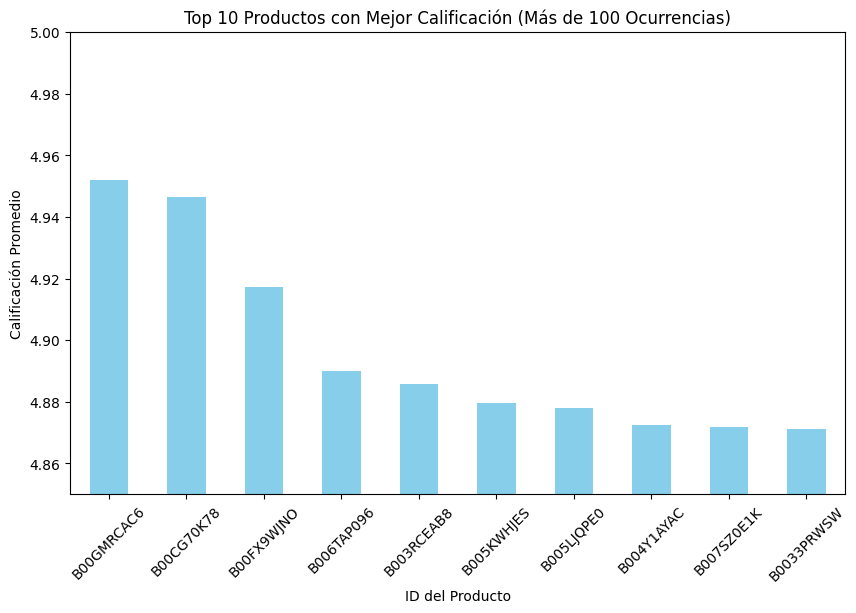

In [37]:
top_10_products = df_best_rating_100.head(10)
plt.figure(figsize=(10, 6))
top_10_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Productos con Mejor Calificación (Más de 100 Ocurrencias)')
plt.xlabel('ID del Producto')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45)
plt.ylim(4.85, 5)
plt.show()

## 3- Seleccion datos relevantes

Este Dataset posee solo la informacion que minimamente debe contener para hacer un sistema de recomendacion. No se le puede quitar datos inicialmente.

## Ordinal Encoder en userId y productId

In [38]:
ordinal_encoder_userId = OrdinalEncoder()
ordinal_encoder_prodId = OrdinalEncoder()

df['userId'] = ordinal_encoder_userId.fit_transform(df[['userId']])
df['productId'] = ordinal_encoder_prodId.fit_transform(df[['productId']])
df['userId'] = df['userId'].astype(int)
df['productId'] = df['productId'].astype(int)
df.head()

,userId,productId,Rating,timestamp,año,mes
2,949671,0,3.0,2013-07-22,2013,7
4,367495,1,5.0,2014-04-14,2014,4
5,1259685,1,2.0,2014-04-14,2014,4
6,912492,1,5.0,2014-03-27,2014,3
7,1055330,1,5.0,2014-03-23,2014,3


In [39]:
df['userId'].nunique()

1883458

In [40]:
df['productId'].nunique()

273849

## Division Train y Test

In [41]:
# Fecha limite, un mes antes del ultimo dato
test_limit = pd.to_datetime("2014-06-23")

train = df[df['timestamp'] < test_limit]
test = df[df['timestamp'] >= test_limit]

In [42]:
#verificacion de la division en train y test
train['timestamp'].max()

Timestamp('2014-06-22 00:00:00')

In [43]:
test['timestamp'].min()

Timestamp('2014-06-23 00:00:00')

In [44]:
len(test)

250117

## Seleccion Usuarios Test

In [45]:
test['userId'].nunique()

181174

In [46]:
unique_users = test['userId'].unique() # Listado de usuarios en test
selected_users = np.random.choice(unique_users, size=50000, replace=False) # Seleccion de 50.000 usuarios de test.
test_selected = test[test['userId'].isin(selected_users)] # Filtrado de esos 50.000 en set de test.
test_selected.shape

(69332, 6)

In [47]:
train_users_list = train['userId'].unique()
train_selected_users = [] # Usuarios que aparecen en train (realizaron compras en el ultimo año).
train_cold_start_users = [] # Usuarios que no aparecen en train (NO realizaron compras el ultimo año)

for user in selected_users:
    if user in train_users_list:
        train_selected_users.append(user)
    else:
        train_cold_start_users.append(user)

print(f"El número de usuarios que usarán el Sistema de Recomendación son: {len(train_selected_users)}")
print(f"El número de usuarios que usarán el Cold Start son: {len(train_cold_start_users)}")

El número de usuarios que usarán el Sistema de Recomendación son: 12336
El número de usuarios que usarán el Cold Start son: 37664


##

## 4- Preparacion para aplicar modelo

In [48]:
# Check numero de usuarios en train selected.
train_selected = train[train['userId'].isin(train_selected_users)]
train_selected['userId'].nunique()

12336

In [49]:
# Numero de compras realizados por los usuarios seleccionados en el periodo de train:
num_buys = train_selected.shape[0]
#Numero de compras promedio realizado por cada usuario en el ultimo año:
average_purchases_per_user_last_year = round(num_buys / train_selected['userId'].nunique() , 2)

print(f'Numero de compras realizados por los usuarios seleccionados en el periodo de train:{num_buys}')
print(f'Numero de compras promedio por los usuarios en el ultimo año: {average_purchases_per_user_last_year}')

Numero de compras realizados por los usuarios seleccionados en el periodo de train:42903
Numero de compras promedio por los usuarios en el ultimo año: 3.48


In [50]:
matrix_columns = ['userId','productId','Rating']

In [51]:
interactions = train_selected[matrix_columns]
interactions.reset_index(drop=True, inplace=True)

In [52]:
interactions

,userId,productId,Rating
0,1733291,28,5.0
1,813290,37,1.0
2,1397524,42,3.0
3,1752884,44,1.0
4,862423,46,3.0
...,...,...,...
42898,788039,273403,4.0
42899,1634741,273437,5.0
42900,1872481,273453,1.0
42901,48367,273602,1.0


In [53]:
pivot_table = interactions.pivot_table(index='userId', columns='productId', values='Rating', fill_value=0)
pivot_table.head()

productId,28,37,42,44,46,49,50,72,81,88,...,273300,273344,273351,273387,273390,273403,273437,273453,273602,273733
userId,,,,,,,,,,,,,,,,,,,,,
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
pivot_table.shape

(12336, 22187)

In [55]:
interactions_matrix_csr = csr_matrix(pivot_table.values)
interactions_matrix_csr

<12336x22187 sparse matrix of type '<class 'numpy.int64'>'
	with 42903 stored elements in Compressed Sparse Row format>

In [56]:
# Creacion de diccionario con keys: usersId, values: indice en la pivot_table.
user_ids = list(pivot_table.index)
user_dict = {}
counter = 0
for i in user_ids:
    user_dict[i] = counter
    counter += 1

user_dict

{101: 0,
 1125: 1,
 1315: 2,
 1521: 3,
 1539: 4,
 1638: 5,
 1643: 6,
 2195: 7,
 2699: 8,
 2710: 9,
 2788: 10,
 2852: 11,
 3082: 12,
 3580: 13,
 3808: 14,
 4061: 15,
 4510: 16,
 4927: 17,
 5013: 18,
 5248: 19,
 5328: 20,
 5386: 21,
 6182: 22,
 6251: 23,
 6760: 24,
 6875: 25,
 7006: 26,
 7284: 27,
 7473: 28,
 7505: 29,
 7538: 30,
 7625: 31,
 7710: 32,
 7732: 33,
 8055: 34,
 8094: 35,
 8151: 36,
 8195: 37,
 8292: 38,
 8294: 39,
 8381: 40,
 8386: 41,
 8407: 42,
 8871: 43,
 9034: 44,
 9068: 45,
 9468: 46,
 9506: 47,
 9640: 48,
 9688: 49,
 9713: 50,
 9860: 51,
 9894: 52,
 9973: 53,
 10144: 54,
 10211: 55,
 10238: 56,
 10585: 57,
 10758: 58,
 10791: 59,
 10914: 60,
 10973: 61,
 11474: 62,
 11500: 63,
 11608: 64,
 11626: 65,
 11843: 66,
 11845: 67,
 11997: 68,
 12163: 69,
 12182: 70,
 12189: 71,
 12852: 72,
 13046: 73,
 13061: 74,
 13067: 75,
 13155: 76,
 13255: 77,
 13415: 78,
 13459: 79,
 13538: 80,
 13732: 81,
 13812: 82,
 13855: 83,
 13977: 84,
 14291: 85,
 14618: 86,
 14648: 87,
 14739: 8

## 5- Cold Start- Best Products

Productos populares y bien rankeados para los usuarios que no compraron en el ultimo año.

In [57]:
len(train_cold_start_users) # Listado de usuarios que no aparecen en test.

37664

Parametros seleccionados para clasificar productos populares.

1.   Train filtrado en el ultimo mes.
2.   Minimo 100 compras.
3.   Average Rating > 4.



In [58]:
from datetime import timedelta
train_limit_CS = test_limit - timedelta(days=30)

train_CS = train[train['timestamp'] >= train_limit_CS]
print(f"Fecha inicial train_CS:{train_CS['timestamp'].min()} ")
print(f"Fecha final train_CS:{train_CS['timestamp'].max()} ")

Fecha inicial train_CS:2014-05-24 00:00:00 
Fecha final train_CS:2014-06-22 00:00:00 


In [59]:
print(f"Cantidad de compras registradas en train_CS: {train_CS.shape[0]}")

Cantidad de compras registradas en train_CS: 209846


In [60]:
train_CS.head()

,userId,productId,Rating,timestamp,año,mes
9,1882935,1,5.0,2014-05-29,2014,5
63,1240961,8,5.0,2014-05-25,2014,5
69,631921,8,5.0,2014-06-16,2014,6
72,1397543,9,5.0,2014-05-28,2014,5
107,1384027,17,4.0,2014-06-16,2014,6


In [61]:
# Obtener productos que fueron comprados mas de 100 veces en este mes.
sales_quantity = train_CS['productId'].value_counts()
sales_quantity_100 = (sales_quantity[sales_quantity.values >= 100])
print(f"En total hay {len(sales_quantity_100)} productos que fueron vendidos mas de 100 veces")

En total hay 130 productos que fueron vendidos mas de 100 veces


In [62]:
train_CS_100 = train_CS[train_CS['productId'].isin(sales_quantity_100.index)]
len(train_CS_100['productId'].value_counts())

130

In [63]:
# Obtener productos con average rating superior a 4.
train_CS_100_R = train_CS_100.groupby('productId')['Rating'].mean() #calcula la media de rating a cada producto
train_CS_100_R4 = train_CS_100_R[train_CS_100_R.values >= 4].sort_values(ascending=False)
train_CS_100_R4

productId
79817     4.838983
239354    4.793991
222083    4.780000
56368     4.776860
257157    4.761468
            ...   
70175     4.025641
227424    4.022872
228835    4.022599
109839    4.016529
55058     4.014815
Name: Rating, Length: 100, dtype: float64

In [64]:
Best_products = train_CS_100_R4.index[:20]
Best_products = Best_products.tolist()
Best_products

[79817,
 239354,
 222083,
 56368,
 257157,
 179024,
 20862,
 185341,
 92346,
 144037,
 41776,
 268210,
 56608,
 231411,
 33359,
 221356,
 65896,
 178972,
 167345,
 212452]

## 6- Entrenamiento de Modelo

In [65]:
model = LightFM(no_components=3,loss='warp', random_state=100, learning_rate=0.01)

In [66]:
model.fit(interactions_matrix_csr, epochs=100 )

In [67]:
recomms_dict = {
    'user_id': [],
    'recomms': [],
    'cold_start' : []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = pivot_table.shape
item_ids = np.arange(n_items)
item_ids

array([    0,     1,     2, ..., 22184, 22185, 22186])

In [68]:
from tqdm import tqdm
#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(selected_users):
    # Validar si el usuario se encuentra en la matriz de interacciones (pivot_table.index)
    if user in list(pivot_table.index):
      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_X = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)
      # Generar las predicciones para el usuario x
      preds = model.predict(user_ids = user_X, item_ids = item_ids)
      # Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      scores = pd.Series(preds)
      scores.index = pivot_table.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]
      # Obtener listado de productos comprados por el usuario (en el set de train).
      bought_products = train[(train['userId']== user)].productId.unique()
      # Filtrar contenidos ya vistos y quedarse con los primeros 20
      recomms = [sc for sc in scores if sc not in bought_products][:20]
      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(list(recomms))
      recomms_dict['cold_start'].append('No')
    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # Les recomendamos contenido popular
      recomms_dict['recomms'].append(Best_products)
      recomms_dict['cold_start'].append('Yes')

100%|██████████| 50000/50000 [04:26<00:00, 187.47it/s]


In [69]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df.head(10)

,user_id,recomms,cold_start
0,375403,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
1,784173,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
2,437445,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
3,621927,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
4,1800531,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
5,906617,"[65795, 131574, 65896, 146762, 170714, 118814,...",No
6,200254,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
7,1182859,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
8,1457632,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
9,519938,"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes


In [70]:
ID_Rec_Sys= train_selected_users[0]
recomm_X = recomms_df[recomms_df['user_id']== ID_Rec_Sys]['recomms'].tolist()
print(f"Id de usuario que recibe el sistema de recomendacion: {ID_Rec_Sys}")
print(f"Lista de recomendacion para usuario:")
recomm_X

Id de usuario que recibe el sistema de recomendacion: 906617
Lista de recomendacion para usuario:


[[65795,
  131574,
  65896,
  146762,
  170714,
  118814,
  127508,
  227424,
  134677,
  196763,
  196284,
  110381,
  104603,
  69775,
  232921,
  123519,
  31179,
  88180,
  259642,
  178972]]

In [71]:
# Check contenido comprado por dicho usuario
products = train[train['userId']==ID_Rec_Sys]
products

,userId,productId,Rating,timestamp,año,mes
245630,906617,4292,4.0,2014-01-13,2014,1
615060,906617,11655,5.0,2013-09-06,2013,9
1030733,906617,18738,4.0,2014-01-15,2014,1
1132375,906617,20834,4.0,2014-01-15,2014,1
1271548,906617,23046,5.0,2014-01-13,2014,1
1783604,906617,32542,5.0,2013-12-22,2013,12
1889363,906617,34742,4.0,2014-01-15,2014,1
1889449,906617,34744,4.0,2014-01-13,2014,1
2076895,906617,38330,5.0,2014-01-13,2014,1
2193188,906617,41292,5.0,2014-01-13,2014,1


In [72]:
# Check productos que el usuario compro en test
products_test = test[test['userId']==ID_Rec_Sys]
products_test

,userId,productId,Rating,timestamp,año,mes
7820921,906617,272774,5.0,2014-06-26,2014,6
7823498,906617,273488,5.0,2014-06-26,2014,6


## Evaluacion del modelo

In [73]:
test_selected # Dataset Test

,userId,productId,Rating,timestamp,año,mes
10,185365,2,5.0,2014-07-18,2014,7
50,1269288,6,3.0,2014-07-04,2014,7
70,674894,8,5.0,2014-06-24,2014,6
133,1124106,18,5.0,2014-06-27,2014,6
186,512417,28,5.0,2014-07-12,2014,7
...,...,...,...,...,...,...
7824437,830147,273830,5.0,2014-07-13,2014,7
7824438,777034,273831,5.0,2014-07-19,2014,7
7824440,446823,273833,5.0,2014-07-20,2014,7
7824441,284336,273833,5.0,2014-07-06,2014,7


In [74]:
# Generacion de tabla con userId - Productos comprados realmente.
ideal_recomms = test_selected.sort_values(by=['userId','Rating'])
ideal_recomms = ideal_recomms.groupby(['userId'], as_index=False).agg({"productId": "unique"})
ideal_recomms.head(10)


,userId,productId
0,6,[71125]
1,69,[175348]
2,96,[143127]
3,101,[86180]
4,195,[256768]
5,231,"[182507, 169860]"
6,470,[193782]
7,689,[177577]
8,814,[148099]
9,838,[89435]


In [75]:
# Generacion de tabla comparativa entre sistema de recomendacion (recomms) y productos comprados (ideal).
df_map = ideal_recomms.merge(recomms_df, how="left", left_on='userId', right_on='user_id')[['userId','productId','recomms','cold_start']]
df_map.columns = ["userId", "ideal", "recomms",'cold_start']
df_map.head()

,userId,ideal,recomms,cold_start
0,6,[71125],"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
1,69,[175348],"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
2,96,[143127],"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes
3,101,[86180],"[178436, 227424, 146762, 231411, 112916, 19293...",No
4,195,[256768],"[79817, 239354, 222083, 56368, 257157, 179024,...",Yes


In [76]:
def MAP_SCORE (df_map):
  aps = [] # lista vacía para ir almacenando la AP de cada recomendación
  for pred, label in df_map[["ideal", "recomms"]].values:
    n = len(pred) # cantidad de elementos recomendados
    arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1
    rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
    tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
    denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
    ap = (tp / denom).sum() / len(label) # average precision
    aps.append(ap)
  MAP_TOTAL = np.mean(aps)
  return f'mean average precision de todos los usuarios = {round(MAP_TOTAL, 5)}'

MAP_SCORE(df_map)

'mean average precision de todos los usuarios = 0.00115'

Dado el bajo resultado de dicho modelo, se estima que es debido mayormente a la gran presencia de usuarios que ingresaron mediante el sistema de Cold-Start.

Se generará un df_map_RS que seran solo los usuarios que ingresaron al sistema desarrollado.

In [77]:
df_map_RS = df_map[df_map['cold_start'] == 'No']
df_map_RS

,userId,ideal,recomms,cold_start
3,101,[86180],"[178436, 227424, 146762, 231411, 112916, 19293...",No
16,1125,[46051],"[227424, 146762, 200783, 65795, 65896, 33359, ...",No
21,1315,"[178162, 150201]","[146762, 227424, 56189, 178436, 131574, 65795,...",No
25,1521,[49104],"[146762, 227424, 56189, 200783, 65896, 178436,...",No
26,1539,"[100638, 236263]","[178436, 227424, 65896, 146762, 231411, 26394,...",No
...,...,...,...,...
49987,1882910,[102442],"[65795, 146762, 227424, 56189, 200783, 65896, ...",No
49990,1883048,[272577],"[178436, 146762, 227424, 200679, 56189, 112916...",No
49991,1883059,[261352],"[227424, 146762, 178436, 65896, 200783, 56189,...",No
49997,1883338,[196417],"[227424, 146762, 200783, 65896, 231411, 178436...",No


In [78]:
MAP_SCORE(df_map_RS)

'mean average precision de todos los usuarios = 0.00156'